In [1]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import functions as fun

In [2]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_3.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_3.csv')
specs_version2= pd.read_csv("/home/jovyan/covid-data/specsSarsCov2-v1-CMPDannot.csv")

#Creating final dataset
data = pd.merge(specs[['ID_library', 'SMILES']], sss_batchA[['ID_covid', 'Intensity_MeanIntensity_illumMITO_cells.1','Labels']], 
                left_on= 'ID_library', right_on='ID_covid', how='left')
data = data.drop(['ID_covid'],axis=1)
data.head() 

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels
0,CBK309065,CC1=NN=C2N1C(SC(C)=C3C)=C3C(C4=CC=C(Cl)C=C4)=N...,0.009294,0
1,CBK041145,[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C...,0.009393,0
2,CBK200894,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,0.009726,0
3,CBK309015,O=C(N1)SC(CC2=CC=C(OCC(N3C)=NC4=C(C=CC=C4)C3=O...,0.011022,0
4,CBK041791,Fc1ccc(cc1)C(c2ccccc2)(c3ccccc3F)n4ccnc4,0.009869,0


In [3]:
# First we need to parse the SMILES and create RDKit 'molecule' objects 
# the 'standardize' function was the one we defined in the first cell with code in this file
data['MOL'] = data['SMILES'].apply(fun.standardize)
data.head()

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
0,CBK309065,CC1=NN=C2N1C(SC(C)=C3C)=C3C(C4=CC=C(Cl)C=C4)=N...,0.009294,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
1,CBK041145,[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C...,0.009393,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
2,CBK200894,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,0.009726,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
3,CBK309015,O=C(N1)SC(CC2=CC=C(OCC(N3C)=NC4=C(C=CC=C4)C3=O...,0.011022,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
4,CBK041791,Fc1ccc(cc1)C(c2ccccc2)(c3ccccc3F)n4ccnc4,0.009869,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."


### There is a problem with some of the smiles as they return none when trying to convert to molecule. The next step is to fix those cases which may be a product of a typo. 

In [4]:
corrupted_smiles_idx_list = data[data['MOL'].isnull()].index.tolist() #finding None values
data[data['MOL'].isnull()]

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
131,CBK309029,O=S(OC1=CC([C@H](O)[C@@H](O)C(NC(C2N(C(C(NC([C...,0.009792,0,None
339,CBK309090,O=C(CC(N)CCCN)NCC(C(N/C(C(NC(C1NC(NCC1)=N)C2=O...,0.009078,0,None
418,CBK309764,CC1=C(CCC(CCCC(C)CCCC(C)CCCC(C)C)(C)O2)C2=C(C)...,0.011273,0,None
447,CBK278005,O=C(C1=C(N)C(C(C)=C2OC3=C(N=C21)C(C(N[C@@H]4C(...,0.009102,0,None
472,CBK309248,C[C@]([C@@](C[C@H]1O)([H])[C@]2(CC[C@@H]3O[C@@...,0.009041,0,None
512,CBK200645,CC[C@H](C)[C@H]1O[C@]2(CC[C@@H]1C)C[C@@H]1C[C@...,0.009255,0,None
682,CBK200530,C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)...,0.009501,0,None
720,CBK309019G,OCC1[N]2(CC[N]3(C4)CC[N]5(C6)CC[N]7(C8)CC2)[Gd...,0.009839,0,None
790,CBK309763G,O=C1[O-][Sb+3]([O-]C(C2[O-]3)C4=O)([O-]4)[O-]C...,0.009371,0,None
857,CBK309767G,O=C1[O-][Mn+2]([N]2(C3)CC4=C5COP(O)(O)=O)([O-]...,0.012623,0,None


In [5]:
specs_v2_smiles = specs_version2[['cbkid', 'smiles']] #Bringing second SPECS data set for comparision

for idx in corrupted_smiles_idx_list:
    compound_in_data = data['ID_library'].values[idx]
    idx_in_specsv2 = specs_v2_smiles.loc[specs_v2_smiles['cbkid'] == compound_in_data].index.tolist()[0]
    #compound_in_specsv2 = specs_v2_smiles['cbkid'].values[idx_in_specsv2]
    smiles_in_data = data['SMILES'].values[idx]
    smiles_in_specs_v2 = specs_v2_smiles['smiles'].values[idx_in_specsv2]
    try:
        mol = Chem.MolFromSmiles(smiles_in_specs_v2)
        data['SMILES'] = data['SMILES'].replace(smiles_in_data, smiles_in_specs_v2)
    except 'None here':
        pass
print('Replacements successful')

Replacements successful


### We can go back to reality 

In [6]:
data = data.drop(['MOL'],axis=1)

#Creating molecue objects again
data['MOL'] = data['SMILES'].apply(fun.standardize)
data.head()

,ID_library,SMILES,Intensity_MeanIntensity_illumMITO_cells.1,Labels,MOL
0,CBK309065,CC1=NN=C2N1C(SC(C)=C3C)=C3C(C4=CC=C(Cl)C=C4)=N...,0.009294,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
1,CBK041145,[H][C@@]12COP([O-])(=O)O[C@@]1([H])[C@@H](O)[C...,0.009393,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
2,CBK200894,CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,0.009726,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
3,CBK309015,O=C(N1)SC(CC2=CC=C(OCC(N3C)=NC4=C(C=CC=C4)C3=O...,0.011022,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."
4,CBK041791,Fc1ccc(cc1)C(c2ccccc2)(c3ccccc3F)n4ccnc4,0.009869,0,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:..."


In [7]:
# Check if any of the SMILES contain multiple fragments - 
# this can sometimes cause issues when computing descriptors
data['FRAGS'] =  data['MOL'].apply(lambda mol: len(Chem.GetMolFrags(mol,asMols=True)))
print("Fragments: {0}".format(data['FRAGS'].nunique()))

Fragments: 1


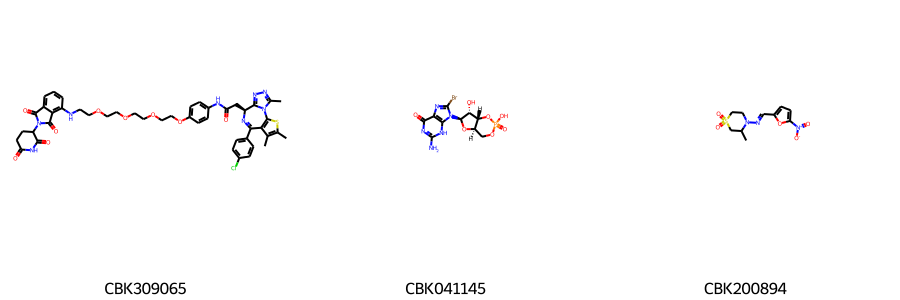

In [8]:
# Compute the descriptors that we're interested in
data['LOGP'] = data['MOL'].apply(lambda mol: Descriptors.MolLogP(mol))
data['HAC'] = data['MOL'].apply(lambda mol: Descriptors.HeavyAtomCount(mol))

# Plot
#plt.figure(figsize=(8,6))
#data.plot.scatter(x='LOGP', y='HAC')
#plt.show()
PandasTools.FrameToGridImage(data[0:3], column='MOL', legendsCol='ID_library', molsPerRow=3, subImgSize=(300, 300))

In [13]:
# Parameters
morgan_radius = 2
morgan_n_bits = 1024
fp_n_bits = 2048

# generate Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(m, morgan_radius, nBits=morgan_n_bits) for m in data['MOL']]
# convert the RDKit explicit vectors into numpy arrays
X_morgan = np.asarray(fps)

# generate RDKFingerprint with default settings
rdkit_fp = [Chem.RDKFingerprint(m, fpSize=fp_n_bits) for m in data['MOL']]
# convert the RDKit explicit vectors into numpy arrays
X_rdkit = np.asarray(rdkit_fp)

# Get the target values 
y = data['Labels'].to_numpy()

In [14]:
# split dataset into train(5 %), test(25 %), unlabel(70 %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_morgan, y_dataset = y, ini_train_size = 0.2, test_size = 0.25)

# Specify our core estimator along with it's active learning model.
n_neighbours = 3
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
learner = ActiveLearner(estimator=knn, X_training = x_train, y_training = y_train)

# Isolate the data we'll need for plotting.
predictions = learner.predict(X_morgan) #test the learner in the complete dataset
is_correct = (predictions == y) #check its performance

# Record our learner's score on the raw data.
unqueried_score = learner.score(x_test, y_test)
print(f' Score without AL: {unqueried_score}')

 Score without AL: 0.9906904577191621


### Now we introduce AL

Accuracy after query 1: 0.9907
Accuracy after query 31: 0.9907
Accuracy after query 61: 0.9907
Accuracy after query 91: 0.9907
Accuracy after query 121: 0.9907
Accuracy after query 151: 0.9907
Accuracy after query 181: 0.9907
Accuracy after query 211: 0.9907
Accuracy after query 241: 0.9907
Accuracy after query 271: 0.9907


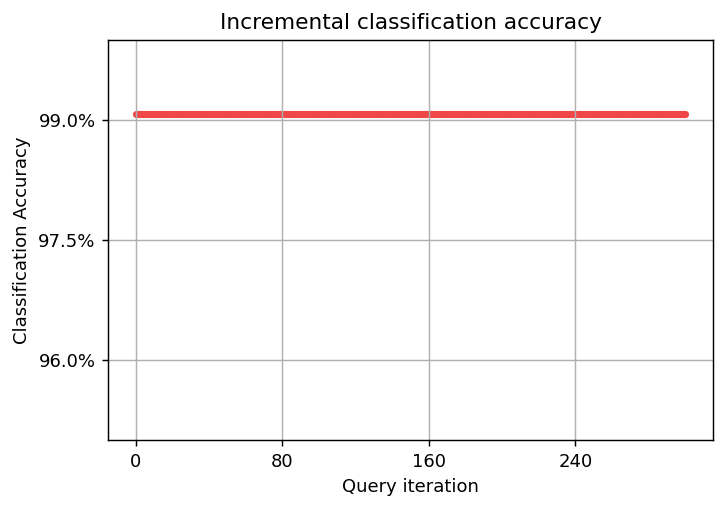

In [15]:
N_QUERIES = 300
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(x_pool)

    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    learner.teach(X=XX, y=yy)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(x_test, y_test)
    
    if index % 30 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

fun.plot_incremental_accuracy(performance_history, save = True, figure_name = 'knn3_0.2_0.25_uncesamp')